<a href="https://colab.research.google.com/github/nanditavenkatesh/Vector-Space-model-and-evaluation-of-word2vec/blob/main/Vector_Space_model_and_evaluation_of_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References
1. Python File Open. (2019). W3schools.com. https://www.w3schools.com/python/python_file_open.asp

2. How to count the occurrences of a list item? (n.d.). Www.tutorialsteacher.com. Retrieved from https://www.tutorialsteacher.com/articles/how-to-count-occurences-of-list-items-in-python

3. Gern Blanston. (2009, March 5). How do I sort a dictionary by value? Stack Overflow. https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

4. Python | Get dictionary keys as a list. (2019, January 28). GeeksforGeeks. https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/

5. Efficiently count zero elements in numpy array? (n.d.). Stack Overflow. Retrieved from https://stackoverflow.com/questions/42916330/efficiently-count-zero-elements-in-numpy-array

6. sklearn.metrics.pairwise.cosine_similarity. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

7. How do I get indices of N maximum values in a NumPy array? (n.d.). Stack Overflow. https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

8. numpy.fill_diagonal — NumPy v1.26 Manual. (n.d.). Numpy.org. Retrieved from https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html

9. NLTK :: Sample usage for gensim. (n.d.). Www.nltk.org. https://www.nltk.org/howto/gensim.html

10. How to get the dimensions of a word2vec vector? (n.d.). Stack Overflow. Retrieved from https://stackoverflow.com/questions/71792841/how-to-get-the-dimensions-of-a-word2vec-vector

11. how to split a text file into multiple list based on whitespacing in python? (n.d.). Stack Overflow. Retrieved from https://stackoverflow.com/questions/28018285/how-to-split-a-text-file-into-multiple-list-based-on-whitespacing-in-python

12. Python Multiprocessing Example | DigitalOcean. (n.d.). Www.digitalocean.com. https://www.digitalocean.com/community/tutorials/python-multiprocessing-example

13. How to check if a key exists in a word2vec trained model or not. (n.d.). Stack Overflow. Retrieved from https://stackoverflow.com/questions/30301922/how-to-check-if-a-key-exists-in-a-word2vec-trained-model-or-not


14. python - Scatter plot with different text at each data point. (n.d.). Stack Overflow. https://stackoverflow.com/questions/14432557/scatter-plot-with-different-text-at-each-data-point

15. How to calculate a logistic sigmoid function in Python? (n.d.). Stack Overflow. Retrieved from https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python


In [ ]:
#@title Get Data
# copy files onto google collab from github
!wget "https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW2/analogies.txt" "analogies.txt"
!wget "https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW2/brown100k.txt" "brown100k.txt"
!wget "https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW2/toefl.txt" "toefl.txt"

--2024-02-19 01:21:52--  https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW2/analogies.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘analogies.txt’

analogies.txt       100%[===================>] 589.80K  3.75MB/s    in 0.2s    

2024-02-19 01:21:52 (3.75 MB/s) - ‘analogies.txt’ saved [603955/603955]

--2024-02-19 01:21:52--  http://analogies.txt/
Resolving analogies.txt (analogies.txt)... failed: Name or service not known.
wget: unable to resolve host address ‘analogies.txt’
FINISHED --2024-02-19 01:21:52--
Total wall clock time: 0.7s
Downloaded: 1 files, 590K in 0.2s (3.75 MB/s)
--2024-02-19 01:21:52--  https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW2/brown100k.txt


In [ ]:
#@title Imports

import pandas as pd
import numpy as np
from itertools import islice
from sklearn.metrics.pairwise import cosine_similarity
from numpy import unravel_index
import gensim.downloader
import random
import matplotlib.pyplot as plt
import math

##Part 1 - Train sparse word vectors

### Data Pre-processing

In [ ]:
# read brown100k
f = open("brown100k.txt", "r")
brown100k = f.read()

In [ ]:
# spilt into tokens
token_brown = brown100k.lower().split()

In [ ]:
# counting the occurrences of each word and storing them in a dictionary
word_count = {}

# get the set of unique words from the full text and counting the occurences of the word
contextSet = list(set(token_brown))

for word in token_brown:
    if word in word_count:
        word_count[word] += 1
    else:
        word_count[word] = 1

# sorting the words in descending order of frequency
word_count = {k: v for k, v in sorted(word_count.items(), key=lambda val: val[1], reverse = True)}

In [ ]:
# take 1000 most frequent words and store in a list
key_list = list(word_count.keys())
vocab = key_list[:1000]

In [ ]:
# Computing the term-term matrix

term_term_matrix = np.zeros((len(vocab),len(contextSet)))

for i,vocab_word in enumerate(vocab):
  for j,token_word in enumerate(token_brown):
    # check if the vocab word is found in the text file
    if vocab_word == token_word:
      # setting context length of 2 before and after the word
      start_context = max(0,j-2)
      end_context = min(len(token_brown),j+3)
      contextwords = token_brown[start_context:j] + token_brown[j + 1:end_context]
      # update the count of the word found in the term-term matrix
      for words in contextwords:
        term_term_matrix[vocab.index(vocab_word)][contextSet.index(words)] += 1

In [ ]:
term_term_matrix.shape

(1000, 13656)

In [ ]:
#@title Find percentage of zeros
number_of_zeros = 0

# count all the zeros
number_of_zeros = np.count_nonzero(term_term_matrix == 0)
print("Number of zeros = ", number_of_zeros)

# compute frequency
freq_of_zeros = (number_of_zeros/(term_term_matrix.shape[0] * term_term_matrix.shape[1])) * 100
print("Frequency of Number of zeros = ", freq_of_zeros)

Number of zeros =  13515296
Frequency of Number of zeros =  98.96965436438195


In [ ]:
#@title Cosine Similarity
picked_word = "president"
# get the vector of the picked word
picked_word_vector = term_term_matrix[vocab.index(picked_word)].reshape(1, -1)
# compute the similarity and store in a single dimensional array
word_similarity = cosine_similarity(picked_word_vector,term_term_matrix)[0]

# find the top 20 most similar values
top_similar_words_index = word_similarity.argsort()[::-1][1:21]

# get the index of the most similar words and make a list of the words
top_similar_words = []
for index in top_similar_words_index:
  top_similar_words.append(vocab[index])

print("List of 20 top similar words are: ", top_similar_words)

List of 20 top similar words are:  ['state', 'first', 'most', 'government', 'administration', 'legislature', 'national', 'house', 'problem', 'in', 'on', 'meeting', 'city', 'and', 'board', 'world', 'battle', 'of', 'value', 'present']


**(i)** Pick a favorite word in the vocabulary. Show the 20 closest words to
the chosen word, calculated using the cosine similarity metric. Are these
what were expected? Why or why not?

**Ans:** I chose the word "president".

List of 20 top similar words are: 'state', 'first', 'most', 'government', 'administration', 'legislature', 'national', 'house', 'problem', 'in', 'on', 'meeting', 'city', 'and', 'board', 'world', 'battle', 'of', 'value', 'present'

Some words are related to the word 'president,' like government, national, administration, and legislature, but some stop words were also observed. However, there is some relationship that I could observe between the other words and the word 'president,' so they are somewhat related. They are syntactically related.

In [ ]:
#@title Most Similar and Most Distinct Word

term_term_cosine_similarity = cosine_similarity(term_term_matrix)

# Most distinct i.e. least similar
distinct_index = unravel_index(term_term_cosine_similarity.argmin(), term_term_cosine_similarity.shape)
print("The most distinct words are: ",vocab[distinct_index[0]]," and " ,vocab[distinct_index[1]])
# Most Similar
# first remove similarity scores of the words with itself
term_term_cosine_similarity_copy = term_term_cosine_similarity.copy()
np.fill_diagonal(term_term_cosine_similarity_copy, -1)
similar_index = unravel_index(term_term_cosine_similarity_copy.argmax(), term_term_cosine_similarity_copy.shape)
print("The most similar words are: ",vocab[similar_index[0]]," and " ,vocab[similar_index[1]])

The most distinct words are:  own  and  ap
The most similar words are:  in  and  on


**(ii)** Which two words in the vocabulary are most distinct? Which are most
similar to each other? Analyze the results obtained.

**Ans:** The most distinct words are:  'own'  and  'ap', The most similar words are:  'in'  and  'on'.
For the most distinct words, own is said to the most distinct from AP (which stands for associated press) this doesn't make a lot of sense to me as AP is an abbreviation and dissimilarity is subjective.
For the most similar words 'in' and 'on' they make a little more sense than the Dissimilar words. These two prepositions can mean similar things and are most grammatically interchanged incorrectly among non-native English speakers, so it can be deduced that they are similar.

In [ ]:
#@title Pre-trained word2vec
GoogleNews_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
vector_dimension = GoogleNews_vectors.vector_size
print("Dimensions of the pre-trained vector: ", vector_dimension)

Dimensions of the pre-trained vector:  300


**(i)** Describe the pre-trained vectors. What are their dimensions? What data
were they pre-trained on? How many word tokens were they pre-trained
on?

**Ans:** The pre-trained vectors are trained from a word2vec model and they are embeddings trained on GoogleNews. The model consists of vectors having a dimension of 300 and for 3 million words and phrases.

In [ ]:
#@title Finding the 20 closest words
print(GoogleNews_vectors.most_similar(positive=['president'], topn = 20))

[('President', 0.800627589225769), ('chairman', 0.6708744764328003), ('vice_president', 0.6700226068496704), ('chief_executive', 0.6691274642944336), ('CEO', 0.6590125560760498), ('pesident', 0.6265207529067993), ('Vice_President', 0.6216662526130676), ('executive', 0.6182477474212646), ('prez', 0.5761911273002625), ('Presdient', 0.5718376636505127), ('Chairman', 0.571763813495636), ('Executive_Director', 0.567531406879425), ('vicepresident', 0.5672553777694702), ('presidents', 0.5596362352371216), ('COO', 0.5593265295028687), ('chairperson', 0.5558380484580994), ('chief', 0.5507432222366333), ('founder', 0.5482356548309326), ('director', 0.5386192202568054), ('vice_presidents', 0.5310230255126953)]


**(ii)** Using the same word as above, show the 20 closest words to it, using
cosine similarity. Has anything changed? Analyze.

**Ans:** Using the word 'president' the 20 closest words were: 'President', 'chairman', 'vice_president', 'chief_executive', 'CEO', 'pesident','Vice_President', 'executive', 'prez', 'Presdient', 'Chairman', 'Executive_Director', 'vicepresident', 'presidents', 'COO', 'chairperson', 'chief', 'founder', 'director', 'vice_presidents'

Yes, the 20 closest words to 'president' were synonyms with the role/position, whereas, with a term-term matrix of context size two, the 20 most similar words are more syntactical.

This is expected because, with a smaller context size we expect to see syntactic relationships more than symantic relationships. Also, the brown corpus used is trained on a much smaller number of tokens than the pre-trained model; hence, there might be tokens in the pre-trained model that the term-term matrix may have never seen.

**(iv)** Which of the two embeddings seem better, based on results?

**Ans:** I think each embedding has its own use case; while word2vec captures more data, and term-term matrices are sparse, the term-term matrix capture syntactic information, and word2vec captured semantic information. Word2vec is also more accurate and does not capture stop words.

## Part 2 - Skip Grams

In [ ]:
# initalize points
data_points = {"w_cat": np.array([1,1]), "c_remote": np.array([0,1]), "c_oatmeal": np.array([0, -1]), "c_litter": np.array([1,0])}

####(1) Plot these four vectors.

**Ans:** Plotted below

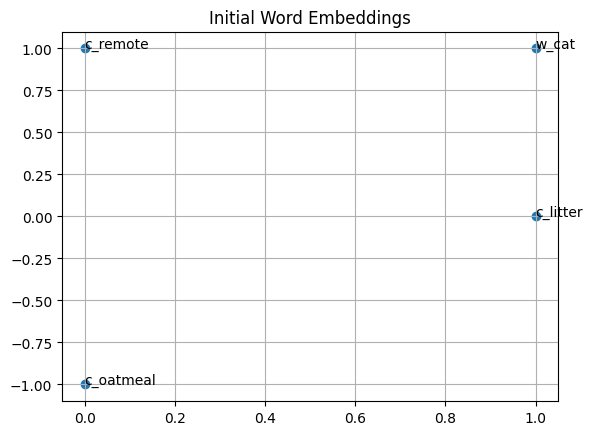

In [ ]:
# plot the points in a graph
x_coords = []
y_coords = []
for x in data_points:
  x_coords.append(data_points[x][0])
  y_coords.append(data_points[x][1])

dp_labels = list(data_points.keys())

fig, ax = plt.subplots()
ax.scatter(x_coords, y_coords)
plt.grid(True)
plt.title('Initial Word Embeddings')

for i, txt in enumerate(dp_labels):
    ax.annotate(txt, (x_coords[i], y_coords[i]))


In [ ]:
#@title Compute sigmoid

def sigmoid(w,c):
  return 1 / (1 + math.exp(-c @ w))

In [ ]:
#@title Compute probability
P = []
for i in range (len(dp_labels)):
  if i != 0:
    P.append(sigmoid(data_points[dp_labels[0]], data_points[dp_labels[i]]))

print("Initial Probabilities: ", P)

Initial Probabilities:  [0.7310585786300049, 0.2689414213699951, 0.7310585786300049]


#### 2) For each of the three tuples in our training example, does the model output that they are context pairs or not? Is the model correct?

**Ans:** The model prediction is incorrect for c_remote. The actual prediction should be 0, but instead, it is 1.

In [ ]:
#@title Compute predictions
initial_preds = [1 if x > 0.5 else 0 for x in P]
print("Initial Predictions: ", initial_preds)

Initial Predictions:  [1, 0, 1]



#### (3) We begin to train our model to arrive at target and context word vectors that will maximize the probability that positive examples are labeled as occurring together and maximize the probability that negative examples are labeled as *not* occurring together using the loss function defined in (6.34 in SLP).


In [ ]:
#@title Compute the loss

y_expected_labels = [-1,0, 0, 1]

def loss_function(point_vectors):
    loss = 0
    for x in range(1, len(dp_labels)):
        if y_expected_labels[x] == 1:
            loss += math.log(sigmoid(point_vectors[dp_labels[0]], point_vectors[dp_labels[x]]))
        elif y_expected_labels[x] == 0:
            loss += math.log(sigmoid(point_vectors[dp_labels[0]], -point_vectors[dp_labels[x]]))
    return loss

print("Initial loss: ", loss_function(data_points))

Initial loss:  -1.9397850625546684


What is the current loss value?

**Ans:** Current loss value is:  -1.9397850625546684

####(4) We perform gradient descent to update our vectors and Step through one step of stochastic gradient descent (considering all three example tuples as one step) and setting the learning rate η = 1.

In [ ]:
#@title Stochastic gradient descent

new_data_points = {}
learning_rate = 1


for x in range(len(dp_labels)):
  # for positive context
  if y_expected_labels[x] == 1:
      new_data_points[dp_labels[x]] = data_points[dp_labels[x]] - learning_rate * (sigmoid(data_points[dp_labels[0]], data_points[dp_labels[x]]) - 1) * data_points[dp_labels[0]]
  # for negative context
  elif y_expected_labels[x] == 0:
     new_data_points[dp_labels[x]] = data_points[dp_labels[x]] - learning_rate * (sigmoid(data_points[dp_labels[0]], data_points[dp_labels[x]])) * data_points[dp_labels[0]]
  # for word
  else:
    temp = 0
    for i in range(1, len(dp_labels)):
      if y_expected_labels[i] == 1:
          temp += (sigmoid(data_points[dp_labels[0]], data_points[dp_labels[i]]) - 1) * data_points[dp_labels[i]]
      elif y_expected_labels[i] == 0:
        temp += (sigmoid(data_points[dp_labels[0]], data_points[dp_labels[i]])) * data_points[dp_labels[i]]
    new_data_points[dp_labels[x]] = data_points[dp_labels[0]] - learning_rate * temp

In [ ]:
for key in new_data_points:
  print (key, ": ", new_data_points[key])

w_cat :  [1.26894142 0.53788284]
c_remote :  [-0.73105858  0.26894142]
c_oatmeal :  [-0.26894142 -1.26894142]
c_litter :  [1.26894142 0.26894142]


What are the updated vectors?

**Ans:** These are the updated values of the vectors:
<br>w_cat :  [1.26894142, 0.53788284]
<br>c_remote :  [-0.73105858,  0.26894142]
<br>c_oatmeal :  [-0.26894142, -1.26894142]
<br>c_litter :  [1.26894142, 0.26894142]

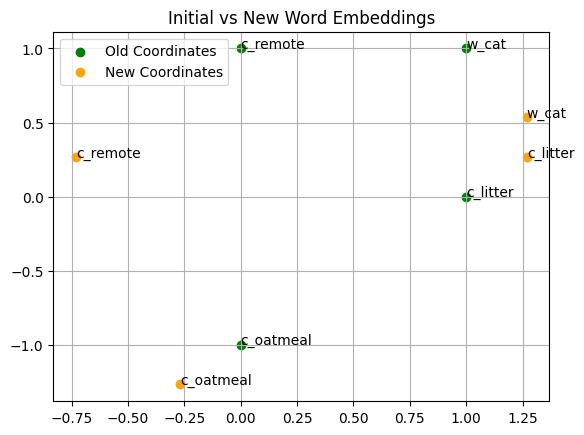

In [ ]:
#@title Plotting the new points in a graph
x_coords_new = []
y_coords_new = []
x_coords = []
y_coords = []
for x in data_points:
    x_coords_new.append(new_data_points[x][0])
    y_coords_new.append(new_data_points[x][1])
    x_coords.append(data_points[x][0])
    y_coords.append(data_points[x][1])

dp_labels = list(data_points.keys())

fig, ax = plt.subplots()
ax.scatter(x_coords, y_coords, color='green', label='Old Coordinates')
ax.scatter(x_coords_new, y_coords_new, color='orange', label='New Coordinates')
plt.grid(True)
plt.title('Initial vs New Word Embeddings')
plt.legend()

for i, txt in enumerate(dp_labels):
    ax.annotate(txt, (x_coords[i], y_coords[i]))

for i, txt in enumerate(dp_labels):
    ax.annotate(txt, (x_coords_new[i], y_coords_new[i]))

plt.show()

In [ ]:
#@title Compute new probability
P_new = []
for i in range (len(dp_labels)):
  if i != 0:
    P_new.append(sigmoid(new_data_points[dp_labels[0]], new_data_points[dp_labels[i]]))

print("New Probabilities: ", P_new)

New Probabilities:  [0.31367119441399455, 0.26428539289602093, 0.8525661633589757]


#### (5) For each of the three tuples and the updated vectors, does the model now make the correct prediction?

**Ans:** All of the updated vectors are now able to make the correct predictions.

In [ ]:
#@title Compute new predictions
new_preds = [1 if x > 0.5 else 0 for x in P_new]
print("New Predictions: ", new_preds)

New Predictions:  [0, 0, 1]



####(6) What is the new loss function value?

**Ans:** The New Loss Value is : -0.8428159170506121


In [ ]:
#@title New Loss value

print("New loss: ", loss_function(new_data_points))

New loss:  -0.8428159170506121


####(7) Describe what has changed and how this will over time work to create word embeddings that represent word similarity. Consider how the predictions, vectors, and loss have changed.

**Ans:** The word 'cat' got much closer to the positive context, i.e., litter; it got much further away from the negative contexts, i.e., 'oatmeal' and 'remote.' This demonstrates how word embeddings will work overtime by pulling similar words (positive contexts) closer; hence, semantically similar words will be closer to each other. Their cosine similarity will result in a higher value.

## Part 3 - Evaluating Word2Vec

### Part 3(a) - Analogies

In [ ]:
#@title Data Pre-processing

def category_lists():
  categories = {}
  category_name = None
  # get the category names and store them in a dictonary
  with open("analogies.txt", 'r') as f:
    for line in f:
      line = line.strip()
      if line.startswith(':'):
          current_category = line[1:].strip()
          categories[current_category] = []
      elif current_category:
        words = line.split()
        categories[current_category].append(words)
  return categories

In [ ]:
categories_lists = category_lists()
print(categories_lists['capital-common-countries'][:5])

[['Athens', 'Greece', 'Baghdad', 'Iraq'], ['Athens', 'Greece', 'Bangkok', 'Thailand'], ['Athens', 'Greece', 'Beijing', 'China'], ['Athens', 'Greece', 'Berlin', 'Germany'], ['Athens', 'Greece', 'Bern', 'Switzerland']]


In [ ]:
# compute predicted word using pre-trained model
def predicted_analogy(analogy_list):
  pred_word = GoogleNews_vectors.most_similar(positive=[analogy_list[1],analogy_list[2]], negative=[analogy_list[0]], topn = 1)
  return (pred_word[0][0])

In [ ]:
# computation of accuracy
def compute_accuracy(category, analogies):
    correct = sum(1 for analogy in analogies if analogy[3] == predicted_analogy(analogy))
    accuracy = correct / len(analogies)
    return category, accuracy

In [ ]:
# predicting analogies
pred_result = {}

for category in categories_lists:
  pred_result[category] = []
  for analogy in categories_lists[category]:
    predicted_word = predicted_analogy(analogy)
    pred_result[category].append(analogy[3] == predicted_word)
  print('Completed ', category)

Completed  capital-common-countries
Completed  capital-world
Completed  currency
Completed  city-in-state
Completed  family
Completed  gram1-adjective-to-adverb
Completed  gram2-opposite
Completed  gram3-comparative
Completed  gram4-superlative
Completed  gram5-present-participle
Completed  gram6-nationality-adjective
Completed  gram7-past-tense
Completed  gram8-plural
Completed  gram9-plural-verbs


In [ ]:
# compute accuracies
accuracies = {}
for category in pred_result:
  accuracies[category] = sum(pred_result[category])/len(pred_result[category])

for accuracy_category in accuracies:
  print("For category ", accuracy_category, " the observed accuracy is: ", accuracies[accuracy_category])

For category  capital-common-countries  the observed accuracy is:  0.8320158102766798
For category  capital-world  the observed accuracy is:  0.7913351016799293
For category  currency  the observed accuracy is:  0.3510392609699769
For category  city-in-state  the observed accuracy is:  0.7089582488852858
For category  family  the observed accuracy is:  0.8458498023715415
For category  gram1-adjective-to-adverb  the observed accuracy is:  0.2852822580645161
For category  gram2-opposite  the observed accuracy is:  0.4273399014778325
For category  gram3-comparative  the observed accuracy is:  0.9084084084084084
For category  gram4-superlative  the observed accuracy is:  0.8734402852049911
For category  gram5-present-participle  the observed accuracy is:  0.78125
For category  gram6-nationality-adjective  the observed accuracy is:  0.8993120700437773
For category  gram7-past-tense  the observed accuracy is:  0.6596153846153846
For category  gram8-plural  the observed accuracy is:  0.898648

#### Conceptual Questions

Report the model’s accuracy by question type. How does the model do?

**Ans:** The observed accuracies for each category is:
<br>1. For category  capital-common-countries  the observed accuracy is:  0.8320158102766798
<br>2. For category  capital-world  the observed accuracy is:  0.7913351016799293
<br>3. For category  currency  the observed accuracy is:  0.3510392609699769
<br>4. For category  city-in-state  the observed accuracy is:  0.7089582488852858
<br>5. For category  family  the observed accuracy is:  0.8458498023715415
<br>6. For category  gram1-adjective-to-adverb  the observed accuracy is:  0.2852822580645161
<br>7. For category  gram2-opposite  the observed accuracy is:  0.4273399014778325
<br>8. For category  gram3-comparative  the observed accuracy is:  0.9084084084084084
<br>9. For category  gram4-superlative  the observed accuracy is:  0.8734402852049911
<br>10. For category  gram5-present-participle  the observed accuracy is:  0.78125
<br>11. For category  gram6-nationality-adjective  the observed accuracy is:  0.8993120700437773
<br>12. For category  gram7-past-tense  the observed accuracy is:  0.6596153846153846
<br>13. For category  gram8-plural  the observed accuracy is:  0.8986486486486487
<br>14. For category  gram9-plural-verbs  the observed accuracy is:  0.6793103448275862

For most categories it has done well apart from currencies, adjective to adverb, opposites, past tense, and pural verbs.



Do you notice patterns in what types of analogies it handles well and what kinds of analogies it handles poorly?


**Ans:** It performs well in data that tends to occur in the pre-training data. It handled geographical data, relationship data, and lexical data well. It performed poorly in different word forms, such as adjectives, adverbs, and opposites. It also performed poorly in currencies; perhaps the model was not exposed to enough data to capture all the currencies.

### Part3(b) - TOEFL Dataset

Note: Changed the spelling of tranquillity to tranquility.

In [ ]:
#@title Data Pre-processing

# getting a list of list of the questions
def questions():
  # get the questions
  toefl_question_list = []
  with open("toefl.txt", 'r') as f:
    for line in f:
      line = line.lower().strip()
      toefl_question_list.append(line.split())
  return toefl_question_list

In [ ]:
question_list = questions()

In [ ]:
# compute similarity scores for each word and find the word with maximum similarity
def predict_synonym(text):
  pred_synonym = []
  accuracy = []
  for question in question_list:
      target = question[1]
      test_word = question[0]
      pred_words = []
      for w in question[1:]:
        pred_words.append(GoogleNews_vectors.similarity(w, test_word))
      max_similarity = np.argmax(np.array(pred_words))
      pred_synonym.append([target, question[max_similarity+1]])
      accuracy.append(1 if (question[max_similarity+1] == target) else 0)
  return pred_synonym, accuracy

predictions, accuracies = predict_synonym(question_list)
print("Predictions: ",predictions)

Predictions:  [['tremendously', 'tremendously'], ['stipulation', 'stipulation'], ['randomly', 'randomly'], ['conspicuous', 'conspicuous'], ['pinnacle', 'pinnacle'], ['imperfect', 'imperfect'], ['desperately', 'desperately'], ['eat', 'eat'], ['come', 'stability'], ['succinctly', 'succinctly'], ['greet', 'ceremony'], ['alone', 'restless'], ['accelerate', 'accelerate'], ['endurance', 'generosity'], ['imaginative', 'imaginative'], ['demonstrate', 'demonstrate'], ['continually', 'continually'], ['subject', 'subject'], ['supply', 'impress'], ['expensive', 'expensive'], ['acknowledge', 'acknowledge'], ['location', 'location'], ['earn', 'earn'], ['frequently', 'frequently'], ['relax', 'relax'], ['argument', 'argument'], ['thin', 'thin'], ['plan', 'explain'], ['limitless', 'limitless'], ['strike', 'prickly'], ['impose', 'impose'], ['skillfully', 'skillfully'], ['circulate', 'commercialize'], ['difference', 'difference'], ['productive', 'productive'], ['unequaled', 'unequaled'], ['uniquely', 'un

In [ ]:
# compute accuracy score
accuracy_score = len(np.where(np.array(accuracies) == 1)[0])/len(accuracies)
print("The Accuracy of the pre-trained model on TOEFL data set is: ", accuracy_score*100)

The Accuracy of the pre-trained model on TOEFL data set is:  83.75


In [ ]:
#@title Random Prediction accuracy
def rand_synonym(text):
  pred_rand = []
  accuracy_rand = []
  for question in question_list:
      target = question[1]
      rand_pred = question[random.randint(1,4)]
      pred_rand.append([target, rand_pred])
      accuracy_rand.append(1 if (rand_pred == target) else 0)
  return pred_rand, accuracy_rand

rand_predictions, rand_accuracies = rand_synonym(question_list)
print("Predictions: ",rand_predictions)

# compute accuracy score for random predictions
rand_accuracy_score = len(np.where(np.array(rand_accuracies) == 1)[0])/len(rand_accuracies)
print("The Accuracy of the pre-trained model on TOEFL data set is: ", rand_accuracy_score*100)

Predictions:  [['tremendously', 'tremendously'], ['stipulation', 'interpretation'], ['randomly', 'densely'], ['conspicuous', 'batter'], ['pinnacle', 'completion'], ['imperfect', 'lustrous'], ['desperately', 'tentatively'], ['eat', 'catch'], ['come', 'arrest'], ['succinctly', 'freely'], ['greet', 'privilege'], ['alone', 'alert'], ['accelerate', 'permit'], ['endurance', 'generosity'], ['imaginative', 'logical'], ['demonstrate', 'demonstrate'], ['continually', 'rapidly'], ['subject', 'subject'], ['supply', 'impress'], ['expensive', 'beautiful'], ['acknowledge', 'successful'], ['location', 'latitude'], ['earn', 'print'], ['frequently', 'chemically'], ['relax', 'bore'], ['argument', 'argument'], ['thin', 'thin'], ['plan', 'plan'], ['limitless', 'limitless'], ['strike', 'entertain'], ['impose', 'correlate'], ['skillfully', 'prudently'], ['circulate', 'research'], ['difference', 'deposit'], ['productive', 'promise'], ['unequaled', 'unequaled'], ['uniquely', 'patriotically'], ['color', 'glare'

#### Conceptual Questions

Report overall accuracy.

**Ans** *Overall accuracy was 83.75%*

How does this compare to chance performance (i.e., the performance you’d expect if the model just chose an answer at random)?

**Ans:** *If we consider a model that selects an answer at random, its accuracy was found to be 30%.(average 25%)*

Are any pattern noticable in the types of questions the model's answers correctly or not?

**Ans:** *I did notice some pattern for a few words for example, 'salute' is predicted to be most similar to ceremony instead of greet. 'solitary' is found to be most similar to restless instead of 'alone'. For these two cases, due to the training data set, the model has considered the syntactic meanings instead of semantic meanings. However, other I could not identify patterns for the other pairs.*